In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from data_preprocessing import preprocess

df = preprocess()

In [2]:
def correlation_matrix(patient_id, wave_option='power_beta', df=df):
    """
    Given one patient_id, it returns a spearman's correlation matrix between the power magnitudes of the
    eeg channels.
    """
    # Select one patient
    patient_data = df[df['id'] == patient_id]

    # Get regions
    regions = patient_data['region'].unique()

    # For each region, we get the power values of the frequencies and save it in a list.
    power_data = []
    for region in regions:
        region_data = patient_data[patient_data['region'] == region]
        power_data.append(region_data[wave_option].values[0])

    # This list is then fed into a pandas dataframe from which we got the spearman's correlation.
    power_df = pd.DataFrame(power_data, index=regions).transpose()
    corr_matrix = power_df.corr(method='spearman')

    return corr_matrix, regions


In [3]:
def average_correlation(patient_ids, wave_option='power_beta'):
    """
    Given a list of patient_ids, returns the average correlation matrix
    """
    correlation_sums = None
    count = 0

    # Loop through each patient and calculate their correlation matrix
    for patient_id in patient_ids:
        corr_matrix, regions = correlation_matrix(patient_id, wave_option)
        
        # Sum all the correlations whilst keeping count of the amount of matrixes
        if correlation_sums is None:
            correlation_sums = corr_matrix
        else:
            correlation_sums += corr_matrix
        
        count += 1

    # Calculate the average
    average_corr_matrix = correlation_sums / count
    return average_corr_matrix, regions

In [4]:
# Get two lists of id's based on whether they are schizophrenic.
healthy_patients = df[df['schizo'] == 0]['id'].unique().tolist()
schizo_patients = df[df['schizo'] == 1]['id'].unique().tolist()

In [5]:
def plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', difference_only=False):
    """
    Helper function which takes in two lists of patient id's, and plots the corresponding correlation matrixes
    """
    # Calculate average correlation matrices for both healthy and schizophrenic patients
    avg_corr_healthy, regions = average_correlation(healthy_patients, wave_option=wave_option)
    avg_corr_schizo, _ = average_correlation(schizo_patients, wave_option=wave_option)
    corr_difference = avg_corr_healthy - avg_corr_schizo

    # Get the regions (they should be consistent across all patients)
    regions = avg_corr_healthy.columns.tolist()  # Get region names from the columns of the correlation matrix
    if difference_only == False:
        # Plot for healthy patients
        plt.figure(figsize=(10, 8))
        sns.heatmap(avg_corr_healthy, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=regions, yticklabels=regions)
        plt.title(f"Average Correlation Matrix for Healthy Patients ({wave_option.capitalize()})")
        plt.xlabel('Regions (Channels)')
        plt.ylabel('Regions (Channels)')
        plt.show()

        # Plot for schizophrenic patients
        plt.figure(figsize=(10, 8))
        sns.heatmap(avg_corr_schizo, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=regions, yticklabels=regions)
        plt.title(f"Average Correlation Matrix for Schizophrenic Patients ({wave_option.capitalize()})")
        plt.xlabel('Regions (Channels)')
        plt.ylabel('Regions (Channels)')
        plt.show()

    # Plot the correlation difference (healthy - schizo)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_difference, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=regions, yticklabels=regions)
    plt.title('Correlation Difference (Healthy - Schizophrenic)')
    plt.xlabel('Regions (Channels)')
    plt.ylabel('Regions (Channels)')
    plt.show()
    
    return avg_corr_healthy, avg_corr_schizo, corr_difference

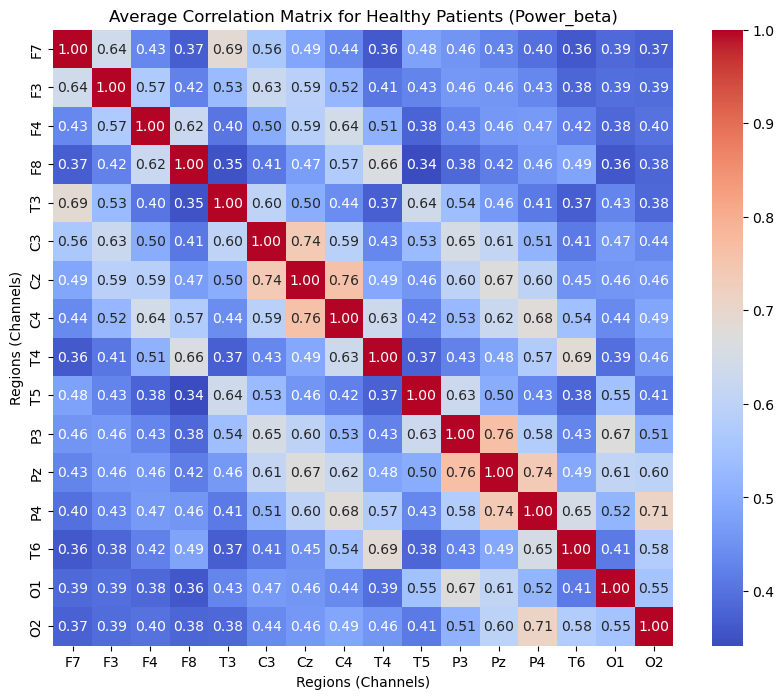

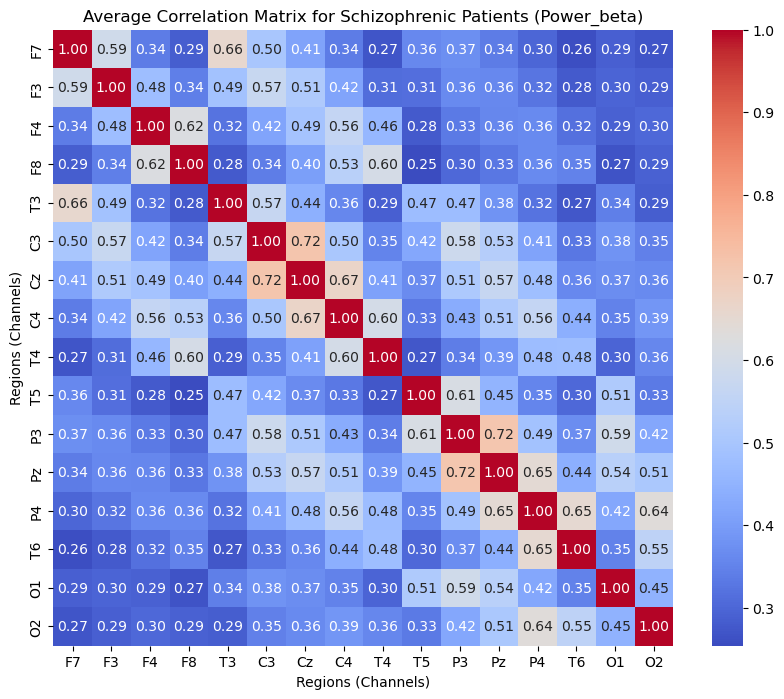

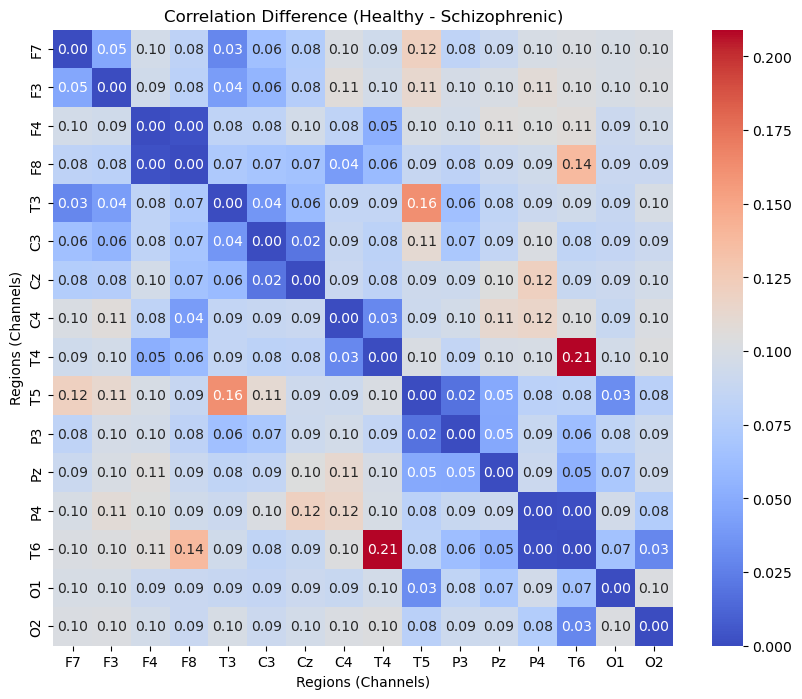

In [6]:
beta_healthy, beta_schizo, beta_dif = plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', difference_only=False)

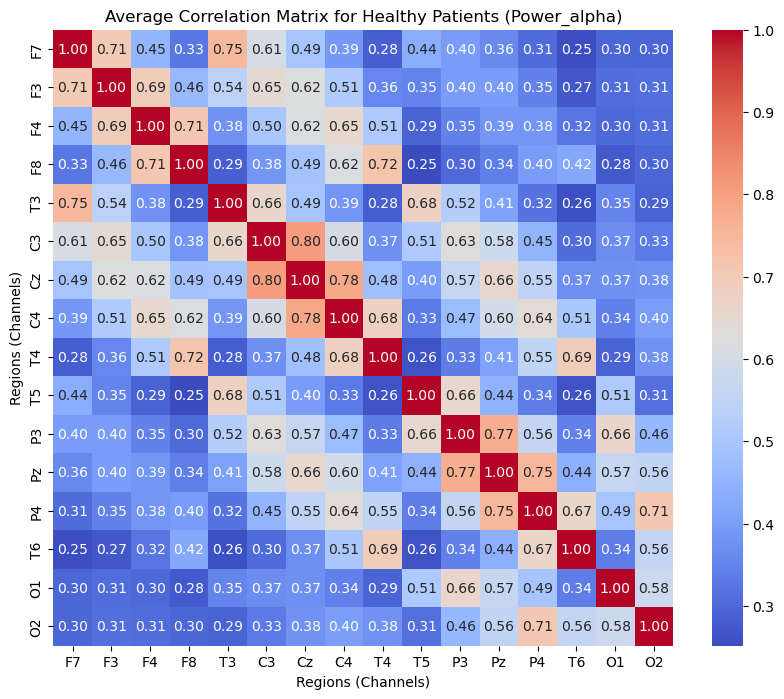

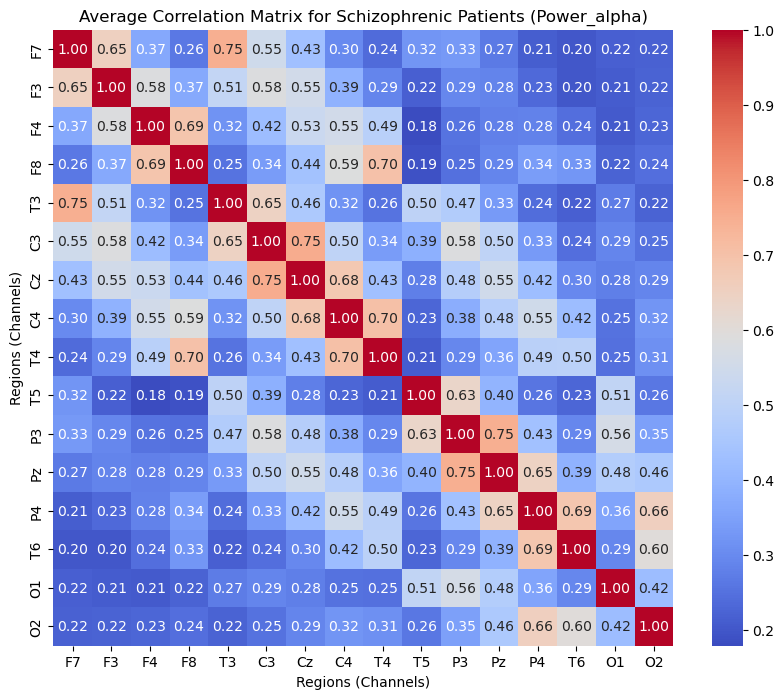

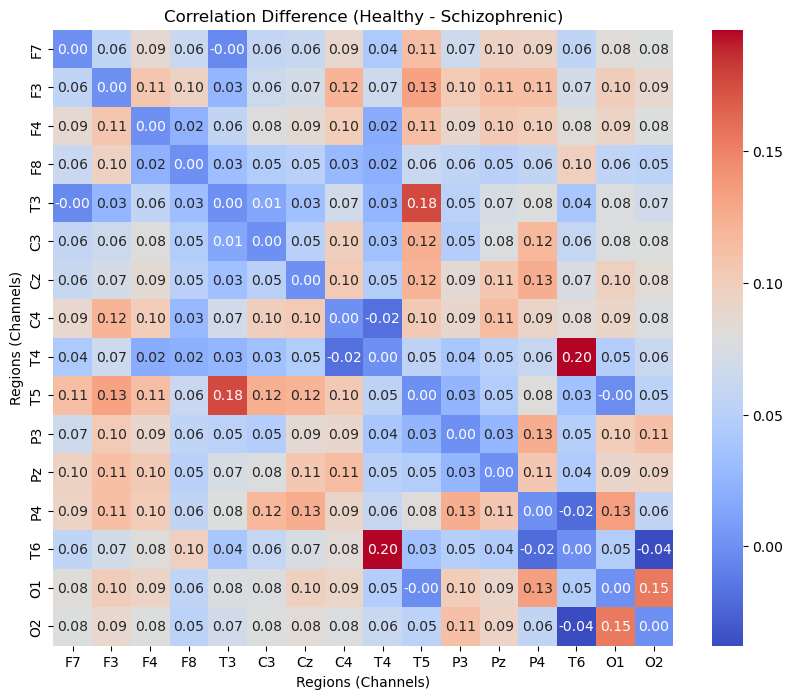

In [7]:
alpha_healthy, alpha_schizo, alpha_dif = plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_alpha')

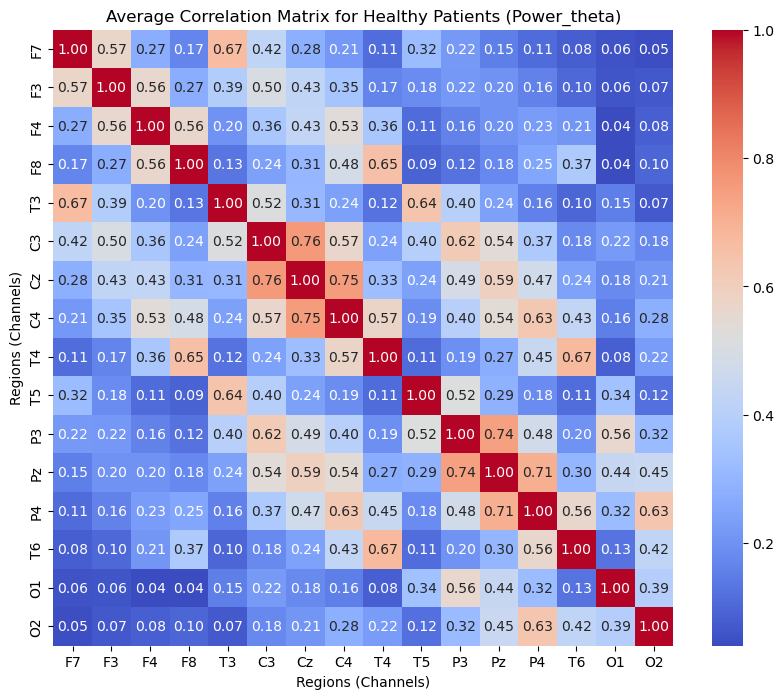

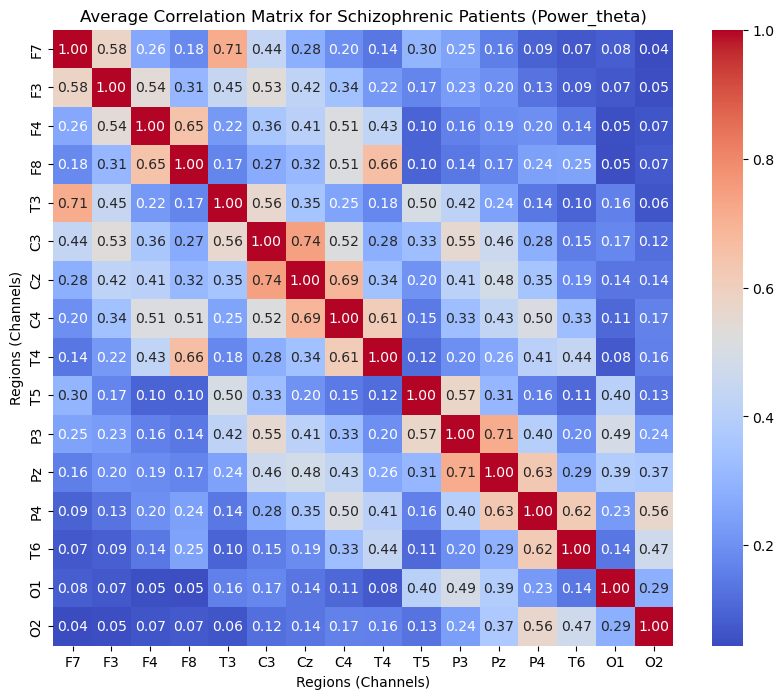

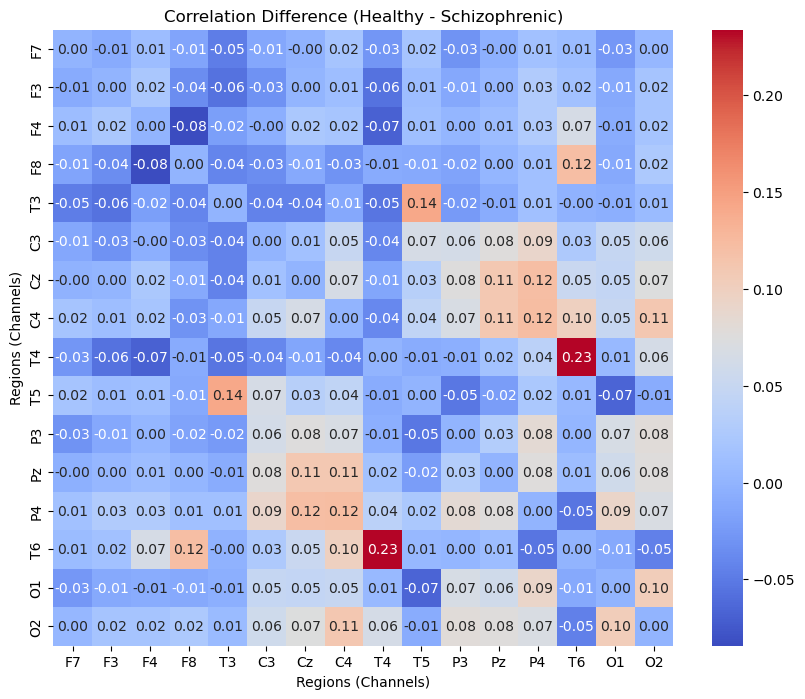

In [8]:
theta_healthy, theta_schizo, theta_dif = plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_theta')

In [9]:
import mne
import numpy as np

def topographical_map(cross_correlation_matrix):
    """
    Creates a topographical map of the correlation matrixes.
    """
    cross_correlation_matrix = np.array(cross_correlation_matrix)

    # The regions our data used, necessary for determining position
    channel_names = [
        "F7", "F3", "F4", "F8",
        "T3", "C3", "Cz", "C4",
        "T4", "T5", "P3", "Pz",
        "P4", "T6", "O1", "O2"
    ]

    # We plot the mean correlation
    channel_correlations = cross_correlation_matrix.mean(axis=1)
    channel_correlations = channel_correlations.reshape(-1, 1)

    # This sets our sensor positions and makes an array necessary for plotting it
    montage = mne.channels.make_standard_montage('standard_1020')
    info = mne.create_info(
        ch_names=channel_names,
        sfreq=128,  # Sampling frequency (adjust if needed)
        ch_types="eeg"
    )
    evoked = mne.EvokedArray(data=channel_correlations, info=info)
    evoked.set_montage(montage)

    # We plot the topomap for a single time position
    times = [0]
    evoked.plot_topomap(
        times=times,
        ch_type='eeg',
        show=True,
        show_names=True,
        size=3,
        vlim=(250000, 700000), # To get something visually interesting we needed to scale it up
        units='Correlation',
        colorbar=True
    )
    plt.show()

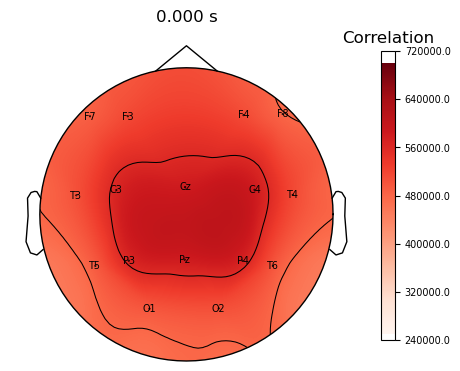

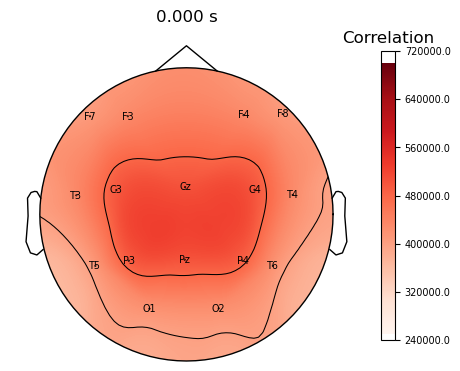

In [10]:
topographical_map(beta_healthy)
topographical_map(beta_schizo)

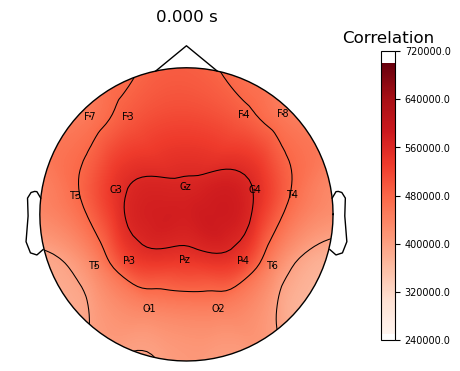

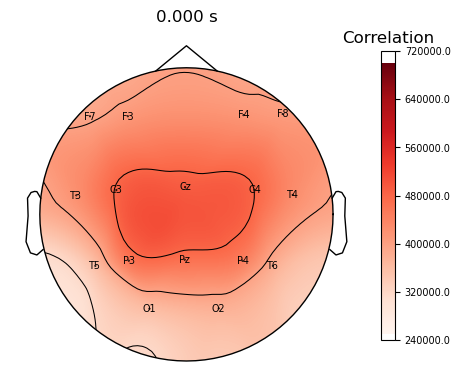

In [11]:
topographical_map(alpha_healthy)
topographical_map(alpha_schizo)

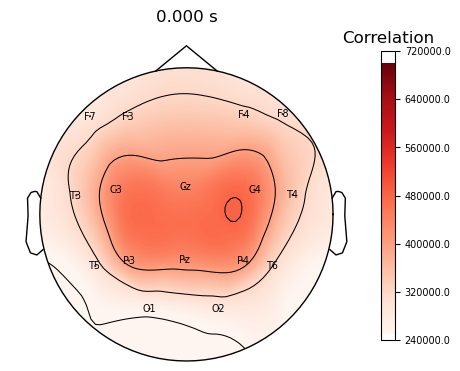

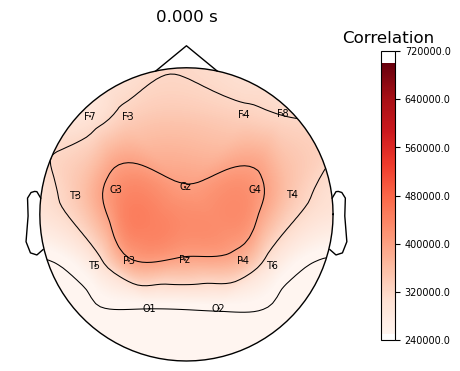

In [12]:
topographical_map(theta_healthy)
topographical_map(theta_schizo)